# FFM原理


# 背景及基本原理


在FM模型中，每一个特征会对应一个隐变量，但在FFM模型中，认为应该将特征分为多个field，每个特征对应每个field分别有一个隐变量。

举个例子，我们的样本有3种类型的字段：publisher, advertiser, gender，分别可以代表媒体，广告主或者是具体的商品，性别。

其中publisher有5种数据，advertiser有10种数据，gender有男女2种，经过one-hot编码以后，每个样本有17个特征，其中只有3个特征非空。

简单来说，同一个categorical特征经过One-Hot编码生成的数值特征都可以放到同一个field。


如果使用FFM模型，则17个特征，每个特征对应3个隐变量，即每个类型对应一个隐变量，具体而言，就是对应publisher, advertiser, gender三个field各有一个隐变量。

在FFM中，每一维特征 $x_i$，针对其它特征的每一种field $f_j$（**其中 $f_j$表示第j维特征所属的field**），都会学习一个隐向量 $v_{i,f_j}$。因此，隐向量不仅与特征相关，也与field相关。

也就是说，**“Day=26/11/15”这个特征与“国家”特征和“广告类型"特征进行关联的时候使用不同的隐向量，这与“国家”和“广告类型”的内在差异相符**。

假设样本的 $n$ 个特征属于 $f$ 个field，那么FFM的二次项有 $nf$个隐向量。

而在FM模型中，每一维特征的隐向量只有一个。FM可以看作FFM的特例，是把所有特征都归属到一个field时的FFM模型。

根据FFM的field敏感特性，可以导出其模型方程。

$$y(x) = w_0 + \sum_{i=1}^n w_i x_i + \sum_{i=1}^n \sum_{j=i+1}^n < v_{i, f_j}, v_{j, f_i} > x_i x_j \tag{4}$$

其中，$f_j$ 是第 $j$ 个特征所属的field。如果隐向量的长度为 $k$，那么FFM的二次参数有 $nfk$ 个，远多于FM模型的 $nk$ 个。此外，由于隐向量与field相关，FFM二次项并不能够化简，其预测复杂度是 $O(kn^2)$。

下面以一个例子简单说明FFM的特征组合方式[9]。输入记录如下

|用户|电影|	电影类型|	价格|
|--|--|--|---|
|user1|三傻|喜剧, 戏剧	|$9.99|


这条记录可以编码成5个特征，其中“电影类型=喜剧”和“电影类型=戏剧”属于同一个field，“Price”是数值型，不用One-Hot编码转换。

为了方便说明FFM的样本格式，我们将所有的特征和对应的field映射成整数编号。

|field name|	Field index|	Feature name|	Feature index|
|--|--|--|---|
|User|	1	|User=YuChin|	1|
|Movie|	2|	Movie=3Idiots|	2|
|Genre|	3|	Genre=Comedy|	3|
||	|	Genre=Drama	|4|
|Price|4|Price|	5|


那么，FFM的组合特征有10项，如下图所示。

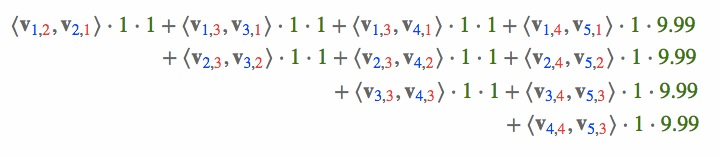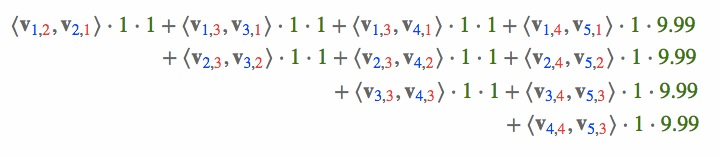

二次项的系数是通过与特征field相关的隐向量点积得到的，二次项共有 $\frac{n(n−1)}{2}$ 个。

事实上，在大多数情况下，FFM模型只保留了二次项部分，省略常数项和一次项，即：

$$\phi(V,x) =  \sum_{i=1}^n \sum_{j=i+1}^n < v_{i, f_j}, v_{j, f_i} > x_i x_j  =\sum_{i=1}^n \sum_{j=i+1}^n (v^T_{i, f_j}v_{j, f_i} ) x_i x_j $$

# 最优化问题


FFM模型采用logistic loss作为损失函数，和L2惩罚项，因此只能用于二元分类问题。根据逻辑回归的损失函数及分析，可以得出FFM的最优化问题为：

$$\min_{\mathbf{v}} \sum_{i=1}^L \log \big( 1 + \exp\{ -y_i \phi (\mathbf{v}, \mathbf{x}_i ) \} \big) + \frac{\lambda}{2} \| \mathbf{v} \|^2$$

中，$y_i∈\{−1,1\}$ 是第 $i$ 个样本的label，$L$ 是训练样本数量，$λ$是惩罚项系数。模型采用SGD优化

# FFM代码实现

符号约定：

$n$:特征的维数

$m$:域的个数

$k$:隐向量的维度

$j$:在特征中的下标

$f$:在域中的下标

$d$:在隐向量中的下标

$l$:样本的总数

粗体字母表示向量或矩阵

**特征组合**

**最基本的线性加权**

$$\phi_{LM}(\textbf{w},\textbf{x})=\sum_{i=1}^n{w_ix_i}$$

**任意特征两两组合**

$$\phi_{poly2}(\textbf{w},\textbf{x})=\sum_{j1=1}^n{\sum_{j2=j1+1}^n{w_{j1,j2}x_{j1}x_{j2}}}$$

$w$是一个对称方阵，即$w_{j1,j2}=w_{j2,j1}$，可以用矩阵分解法来拟合$w$。

$$w_{j1,j2}=\textbf{v}_{j1}\cdot\textbf{v}_{j2}=\textbf{v}_{j2}\cdot\textbf{v}_{j1}=w_{j2,j1}$$

矩阵$w$的规模是$n×n$，矩阵$v$的规模是$n×k$，$k≪n$。实际上我们已经推导出了因子分解法。

**因子分解法FM**

$$\phi_{FM}(\textbf{w},\textbf{x})=\sum_{j1=1}^n{\sum_{j2=j1+1}^n{\textbf{w}_{j1}\cdot \textbf{w}_{j2}x_{j1}x_{j2}}}$$

这里的$w_j$相当于上面的$v_j$。

**域感知的因子分解法FFM**

$$\phi_{FFM}(\textbf{w},\textbf{x})=\sum_{j1=1}^n{\sum_{j2=j1+1}^n{\textbf{w}_{j1,f2}\cdot \textbf{w}_{j2,f1}x_{j1}x_{j2}}}$$

在FM中w是规模为$n×k_{FM}$的二维矩阵，而在FFM中$w$是规模为$n×m×k_{FFM}$的三维矩阵，$k_{FFM}≪k_{FM}$。

**逻辑回归二分类**

**决策函数**

$$\hat{y}=\frac{1}{1+exp(-\phi_{FFM}(\textbf{w},\textbf{x}))}$$

**带L2正则的目标函数**

$$\min_{\textbf{w}}\;\;\frac{\lambda}{2}\parallel w\parallel_2^2+\sum_{i=1}^llog(1+exp(-y_i\phi_{FFM}(\textbf{w},\textbf{x}_i)))$$

> 其中$y_i∈\{−1,1\}$，注意，虽然在预测结果出来的是0-1之间数，但是训练时的y值取-1或1，所以当训练结束后，及测试集上测试，评估模型时，要将测试集的y值转换为0-1。

在SGD中每次只需要考虑一个样本的损失，此时目标函数为

$$\min_{\textbf{w}}\;\;\frac{\lambda}{2}\parallel w\parallel_2^2+log(1+exp(-y\phi_{FFM}(\textbf{w},\textbf{x})))$$

**梯度**

$$\textbf{g}_{j1,f2}=\lambda\cdot\textbf{w}_{j1,f2}+\kappa\cdot\textbf{w}_{j2,f1}x_{j1}x_{j2}$$

$$\textbf{g}_{j2,f1}=\lambda\cdot\textbf{w}_{j2,f1}+\kappa\cdot\textbf{w}_{j1,f2}x_{j1}x_{j2}$$

梯度之所会这么简单，依赖一个很重要的前提：同一个域下的各个特征只有一个是非0值。

其中

$$\kappa=\frac{\partial log(1+exp(-y\phi_{FFM}(\textbf{w},\textbf{x})))}{\partial\phi_{FFM}(\textbf{w},\textbf{x})}=\frac{-y}{1+exp(y\phi_{FFM}(\textbf{w},\textbf{x}))}$$

**AdaGrad更新w**

$$(G_{j1,f2})_d\gets(G_{j1,f2})_d+(g_{j1,f2})_d^2$$
$$(G_{j2,f1})_d\gets(G_{j2,f1})_d+(g_{j2,f1})_d^2$$
$$(w_{j1,f2})_d\gets(w_{j1,f2})_d-\frac{\eta}{\sqrt{(G_{j1,f2})_d}}(g_{j1,f2})_d$$
$$(w_{j2,f1})_d\gets(w_{j2,f1})_d-\frac{\eta}{\sqrt{(G_{j2,f1})_d}}(g_{j2,f1})_d$$

初始化$G_d=1$，这样在计算$\frac{\eta}{\sqrt{G_d}}$时既可以防止分母为0，又可以避免该项太大或太小。

$η$是学习率，通常可取0.01。

初始的$w$可以从均匀分布中抽样$\textbf{w}\sim U(0,\frac{1}{\sqrt{k}})$

实现发现将每个$x$归一化，即模长为1，在测试集得到的准确率会稍微好一点且对参数不太敏感。